TEAM : NEUROCOP


# PART 1 OF PA2

In [23]:
import z3

In [24]:
# Define the ReLU function 
def relu(v):
    return z3.If(v <= 0.0, 0.0, v)

In [32]:
import numpy as np
import random

# Define the network architecture
architecture = [2, 2, 2, 2, 2]  # 2 inputs, 3 hidden layers (with 3, 4, 3 neurons), and 3 outputs

# Function to initialize weights and biases for each layer
def create_random_nn(architecture):
    network = []
    for i in range(1, len(architecture)):
        layer = []
        for j in range(architecture[i]):
            weights = np.random.uniform(-5, 5, architecture[i - 1])  # Random weights for each neuron
            weights = np.around(weights,2)
            bias = round(np.random.uniform(-5, 5),1)  # Random bias for each neuron
            activation_function = True if i < len(architecture) - 1 else False
            if(i == len(architecture)-1):
                neuron = (z3.Real(f'o{j}'),weights, bias, activation_function)
            else:
                neuron = (z3.Real(f'n{i - 1}_{j}'),weights, bias, activation_function)
                
#             neuron = (f'n{i - 1}_{j}', weights, bias, activation_function)
            
            layer.append(neuron)
        network.append(layer)
    return network

# Create the neural network with random weights and biases for the architecture above
dnn = create_random_nn(architecture)

i0 = z3.Real('i0')
i1= z3.Real('i1')
input_var = [i0,i1]
print("Input layer:",input_var)


Input layer: [i0, i1]


In [33]:

# Print the architecture
for i, layer in enumerate(dnn):
    print(f"Layer {i}:")
    for neuron in layer:
        print(neuron)


Layer 0:
(n0_0, array([-4.88, -1.33]), -1.5, True)
(n0_1, array([ 3.98, -0.57]), 1.5, True)
Layer 1:
(n1_0, array([3.29, 0.01]), -1.5, True)
(n1_1, array([-0.96, -2.64]), -0.9, True)
Layer 2:
(n2_0, array([ 1.82, -0.19]), -0.2, True)
(n2_1, array([-4.11, -4.83]), -1.4, True)
Layer 3:
(o0, array([-3.88,  3.14]), -2.7, False)
(o1, array([2.19, 4.08]), 2.6, False)


In [34]:
#Function helps in creating an array of neuron input values which is used for symbolic execution
def create_neurons(dnn,input_var):
    neurons=[]
    neurons.append(input_var)
    for i,layer in enumerate(dnn):
        temp_neurons=[]
        for j,(neuron, weight, b, r) in enumerate(layer):
            temp_neurons.append(dnn[i][j][0])
        neurons.append(temp_neurons)
    return(neurons)
        
        
create_neurons(dnn,input_var)    

[[i0, i1], [n0_0, n0_1], [n1_0, n1_1], [n2_0, n2_1], [o0, o1]]

In [36]:
#my_symbolic_execution function which will return a expression used to solve for states of the neurons
def my_symbolic_execution(input_var, dnn):
    neurons = create_neurons(dnn,input_var)
    res = []
    for i, layer in enumerate(dnn):
        for j, (neuron, weight, b, r) in enumerate(layer):
            w_sum = sum(var * w for var, w in zip(neurons[i], weight))            
            if b!= 0: #bias
                w_sum += b
            if r:    #relu activation
                w_sum = relu(w_sum)
            res.append(neuron == w_sum)
    return(z3.And(res))

In [37]:
# time the execution
import time
if __name__ == "__main__":
    states = my_symbolic_execution(input_var,dnn)
    assert z3.is_expr(states)
    st = time.time()
    u = z3.solve(states)
    print('time to solve: ', time.time() - st)

[n2_0 = 0,
 i0 = -295690/788613,
 n1_0 = 10/141,
 o0 = -27/10,
 o1 = 13/5,
 n0_1 = 10/141,
 n0_0 = 7380/15463,
 i1 = -1661890/14983647,
 n2_1 = 0,
 n1_1 = 0]
time to solve:  0.178131103515625


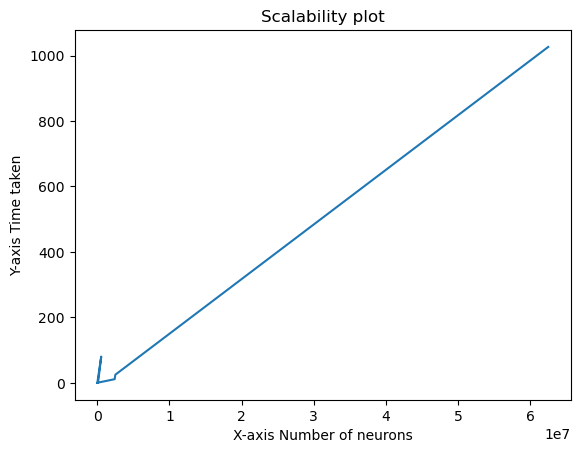

In [40]:
#plot a graph and see the scalability , x axis represents the size of the neuron network and y axis represents 
#the time taken 
import matplotlib.pyplot as plt

x = [32,216, 384, 1024,540000, 100000,2400000,2500000,62500000]
y = [0.08,0.33, 0.047, 0.08, 80.422, 0.98,11.48,25.18,1026.23]

# Create a line plot
plt.plot(x, y)

# Add labels and a title
plt.xlabel('X-axis Number of neurons')
plt.ylabel('Y-axis Time taken')
plt.title('Scalability plot')

# Show the plot 
plt.show()

#time taken increases exponentially as the number of neurons increases.

# Part 2 of PA2

# concrete example

In [51]:
def relu(x):
    return max(0, x)

In [52]:
#Concrete dnn example
hidden_layer0 = [([1.0, -1.0], 0.0, True), ([1.0, 1.0], 0.0, True)]
hidden_layer1 = [([0.5, -0.2], 0.0, True), ([-0.5, 0.1], 0.0, True)]
output_layer = [([1.0, -1.0], 0.0, False), ([-1.0, 1.0], 0.0, False)]
dnn = [hidden_layer0, hidden_layer1,output_layer]
input_var = [[1, 1], [-1, -1]]
pre = {'i0': [1, 1], 'i1': [-1, -1]}

In [53]:
#Helper function to assign the calculated values from previous layer to the next layer from the dictionary 
def finalassignval(input_layer_dict,hidden_layer_dict,layer_idx):
    filtered_dict = {}
    if layer_idx==0:
        nodename=f'i{layer_idx}'
        filtered_values = [value for key, value in input_layer_dict.items() if key.startswith(nodename)]        
    else:
        nodename = f'n{layer_idx-1}_'
        filtered_values = [value for key, value in hidden_layer_dict.items() if key.startswith(nodename)]
#     print("filtered_dict",filtered_values)
    return filtered_values

In [54]:
#Helper function to compute weights
import numpy as np


def compute_weight(weights, bias, use_relu, input_interval):
    # Initialize the interval for the node's output
    output_interval = [0.0, 0.0]  # Initialize to [0, 0]

    # Check if all input intervals are completely less than zero or greater than zero
    input_below_zero = all(ub <= 0 for lb, ub in input_interval)
    input_above_zero = all(lb >= 0 for lb, ub in input_interval)

    # Handle cases where input_interval is entirely below or above zero
    if input_below_zero:
        output_interval[0] = 0.0
        output_interval[1] = 0.0
    elif input_above_zero:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += lower_bound
            output_interval[1] += upper_bound
        output_interval[0] += bias
        output_interval[1] += bias
    else:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += min(lower_bound, upper_bound)
            output_interval[1] += max(lower_bound, upper_bound)
        output_interval[0] += bias
        output_interval[1] += bias

    # Apply ReLU activation function if required
    if use_relu:
        output_interval[0] = relu(output_interval[0])
        output_interval[1] = relu(output_interval[1])

    return output_interval
    

In [55]:
#my_interval_execution function that solves for the intervals for each node
def my_interval_execution(dnn, input_intervals, pre):
    input_layer_dict = {}
    output_layer_dict = {}
    hidden_layer_dict = {}
    
     #Set inputlayer dictionary with the values you are passing to compute weight
    input_layer_dict['i0'] = input_var[0]
    input_layer_dict['i1'] = input_var[1]
    
    #apply pre condition on the input layer
    if pre:
        for key, value in pre.items():
            input_layer_dict[key] = value
#             print(input_layer_dict)
            
    # Initialize the result dictionary
    result = {}
    
    for layer_index, layer in enumerate(dnn):
        interval_values = finalassignval(input_layer_dict,hidden_layer_dict,layer_index)
        for node_index, (weights, bias, use_relu) in enumerate(layer):
            if layer_index != len(dnn) - 1: 
                node_name = f'n{layer_index}_{node_index}'
            else:
                node_name = f'o{node_index}'
            if layer_index == 0 :
#                 print("layer0 input interval:",input_interval)
                output_interval = compute_weight(weights, bias, use_relu,input_var )
            else:
                output_interval = compute_weight(weights, bias, use_relu, interval_values)

            # Update the relevant dictionary based on layer type
            if layer_index == len(dnn) - 1:
                result[node_name] = output_interval
            else:
                hidden_layer_dict[node_name] = output_interval

            # Update the input intervals for the next layer
            input_layer_dict[f'i{node_index}'] = output_interval

    # Combine input, output, and hidden node intervals into the result dictionary
    result.update(input_layer_dict)
    result.update(hidden_layer_dict)

    return result
        

In [56]:
output_intervals = my_interval_execution(dnn, input_var, pre)
# print(output_intervals)
# Print the result
for key, value in output_intervals.items():
    print(f'{key}: {value}')

o0: [1.0, 1.0]
o1: [-1.0, -1.0]
i0: [1.0, 1.0]
i1: [-1.0, -1.0]
n0_0: [2.0, 2.0]
n0_1: [0, 0]
n1_0: [1.0, 1.0]
n1_1: [0, 0]


# Execute using precondition

In [90]:
#create dnn with the given input
hidden_layer0 = [([1.0, -1.0], 0.0, True), ([1.0, 1.0], 0.0, True)]
hidden_layer1 = [([0.5, -0.2], 0.0, True), ([-0.5, 0.1], 0.0, True)]
output_layer = [([1.0, -1.0], 0.0, False), ([-1.0, 1.0], 0.0, False)]
dnn = [hidden_layer0, hidden_layer1,output_layer]
input_var = [[0.1, 0.3], [-0.7, 0.0]]
pre={'i0':[0.1, 0.3], 'i1':[-0.7, 0.0]}

In [91]:
import numpy as np


def compute_weight(weights, bias, use_relu, input_interval):
    # Initialize the interval for the node's output
    output_interval = [0.0, 0.0]  # Initialize to [0, 0]

    # Check if all input intervals are completely less than zero or greater than zero
    input_below_zero = all(ub <= 0 for lb, ub in input_interval)
    input_above_zero = all(lb >= 0 for lb, ub in input_interval)

    # Handle cases where input_interval is entirely below or above zero
    if input_below_zero:
        output_interval[0] = 0.0
        output_interval[1] = 0.0
    elif input_above_zero:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += lower_bound
            output_interval[1] += upper_bound
        output_interval[0] += bias
        output_interval[1] += bias
    else:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += min(lower_bound, upper_bound)
            output_interval[1] += max(lower_bound, upper_bound)
        output_interval[0] += bias
        output_interval[1] += bias

    # Apply ReLU activation function if required
    if use_relu:
        output_interval[0] = relu(output_interval[0])
        output_interval[1] = relu(output_interval[1])

    return output_interval
    

In [92]:
def finalassignval(input_layer_dict,hidden_layer_dict,layer_idx):
    filtered_dict = {}
    if layer_idx==0:
        nodename=f'i{layer_idx}'
        filtered_values = [value for key, value in input_layer_dict.items() if key.startswith(nodename)]        
    else:
        nodename = f'n{layer_idx-1}_'
        filtered_values = [value for key, value in hidden_layer_dict.items() if key.startswith(nodename)]
    return filtered_values
    


In [93]:
def my_interval_execution(dnn, input_intervals, pre):
    input_layer_dict = {}
    output_layer_dict = {}
    hidden_layer_dict = {}
    
     #Set inputlayer dictionary with the values you are passing to compute weight
    input_layer_dict['i0'] = input_var[0]
    input_layer_dict['i1'] = input_var[1]
    
    #apply pre condition on the input layer
    if pre:
        for key, value in pre.items():
            input_layer_dict[key] = value
#             print(input_layer_dict)
            
    # Initialize the result dictionary
    result = {}
    
    for layer_index, layer in enumerate(dnn):
        interval_values = finalassignval(input_layer_dict,hidden_layer_dict,layer_index)
        for node_index, (weights, bias, use_relu) in enumerate(layer):
            if layer_index != len(dnn) - 1: 
                node_name = f'n{layer_index}_{node_index}'
            else:
                node_name = f'o{node_index}'
            if layer_index == 0 :
#                 print("layer0 input interval:",input_interval)
                output_interval = compute_weight(weights, bias, use_relu,input_var )
            else:
                output_interval = compute_weight(weights, bias, use_relu, interval_values)

            # Update the relevant dictionary based on layer type
            if layer_index == len(dnn) - 1:
                result[node_name] = output_interval
            else:
                hidden_layer_dict[node_name] = output_interval

            # Update the input intervals for the next layer
            input_layer_dict[f'i{node_index}'] = output_interval

    # Combine input, output, and hidden node intervals into the result dictionary
    result.update(input_layer_dict)
    result.update(hidden_layer_dict)

    return result
        

In [102]:
import time
start_time = time.time()  # Record the start time
output_intervals = my_interval_execution(dnn, input_var, pre)
end_time = time.time()  # Record the end time

# Calculate the elapsed time
elapsed_time = end_time - start_time
# print(output_intervals)
# Print the result
for key, value in output_intervals.items():
    print(f'{key}: {value}')
print(elapsed_time)

o0: [0.05, 0.44]
o1: [-0.05, -0.44]
i0: [0.05, 0.44]
i1: [-0.05, -0.44]
n0_0: [0.1, 1.0]
n0_1: [0, 0.3]
n1_0: [0.05, 0.44]
n1_1: [0, 0]
0.00011897087097167969


# Checking assertions, i.e., verifying/proving properties about the DNN

In [97]:
print("Yes, Its a valid property since o0 :",output_intervals['o0'])
    # MANUAL checking for the given input if the value of o0 is within the specified bounds ie  0 <= o0 <= 1
    # check that the output interval of o0 is COMPLETELY BETWEEN [0, 1].  If the answer is YES, then the property is proved. Otherwise, it is not proved.  
    # In our case the output is {..., 'o0': [0.05, 0.44], 'o1': [-0.05, -0.44]} hence YES, this property 0 <= o0 <= 1 is proved because 0.05, 0.44 is included in [0.1]

Yes, Its a valid property since o0 : [0.05, 0.44]


# My own example

In [118]:
#Our own example
hidden_layer0 = [([1.0, -1.0], 1.0, True), ([1.0, 1.0], 1.0, True)]
hidden_layer1 = [([0.5, -0.2], 1.0, True), ([-0.5, 0.1], 1.0, True)]
hidden_layer2 = [([1.0, -1.0], 1.0, False), ([-1.0, 1.0], 1.0, False)]
output_layer = [([1.0, -1.0], 0.0, False), ([-1.0, 1.0], 0.0, False)]
dnn = [hidden_layer0,hidden_layer1, hidden_layer2,output_layer]
input_var = [[1, 1], [-1, -1]]
pre = {'i0': [1, 1], 'i1': [-1, -1]}

In [119]:
import numpy as np


def compute_weight(weights, bias, use_relu, input_interval):
    # Initialize the interval for the node's output
    output_interval = [0.0, 0.0]  # Initialize to [0, 0]

    # Check if all input intervals are completely less than zero or greater than zero
    input_below_zero = all(ub <= 0 for lb, ub in input_interval)
    input_above_zero = all(lb >= 0 for lb, ub in input_interval)

    # Handle cases where input_interval is entirely below or above zero
    if input_below_zero:
        output_interval[0] = 0.0
        output_interval[1] = 0.0
    elif input_above_zero:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += lower_bound
            output_interval[1] += upper_bound
        output_interval[0] += bias
        output_interval[1] += bias
    else:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += min(lower_bound, upper_bound)
            output_interval[1] += max(lower_bound, upper_bound)
        output_interval[0] += bias
        output_interval[1] += bias

    # Apply ReLU activation function if required
    if use_relu:
        output_interval[0] = relu(output_interval[0])
        output_interval[1] = relu(output_interval[1])

    return output_interval
    

In [120]:
def finalassignval(input_layer_dict,hidden_layer_dict,layer_idx):
    filtered_dict = {}
    if layer_idx==0:
        nodename=f'i{layer_idx}'
        filtered_values = [value for key, value in input_layer_dict.items() if key.startswith(nodename)]        
    else:
        nodename = f'n{layer_idx-1}_'
        filtered_values = [value for key, value in hidden_layer_dict.items() if key.startswith(nodename)]
    return filtered_values
    


In [121]:
def my_interval_execution(dnn, input_intervals, pre):
    input_layer_dict = {}
    output_layer_dict = {}
    hidden_layer_dict = {}
    
     #Set inputlayer dictionary with the values you are passing to compute weight
    input_layer_dict['i0'] = input_var[0]
    input_layer_dict['i1'] = input_var[1]
    
    #apply pre condition on the input layer
    if pre:
        for key, value in pre.items():
            input_layer_dict[key] = value
#             print(input_layer_dict)
            
    # Initialize the result dictionary
    result = {}
    
    for layer_index, layer in enumerate(dnn):
        interval_values = finalassignval(input_layer_dict,hidden_layer_dict,layer_index)
        for node_index, (weights, bias, use_relu) in enumerate(layer):
            if layer_index != len(dnn) - 1: 
                node_name = f'n{layer_index}_{node_index}'
            else:
                node_name = f'o{node_index}'
            if layer_index == 0 :
#                 print("layer0 input interval:",input_interval)
                output_interval = compute_weight(weights, bias, use_relu,input_var )
            else:
                output_interval = compute_weight(weights, bias, use_relu, interval_values)

            # Update the relevant dictionary based on layer type
            if layer_index == len(dnn) - 1:
                result[node_name] = output_interval
            else:
                hidden_layer_dict[node_name] = output_interval

            # Update the input intervals for the next layer
            input_layer_dict[f'i{node_index}'] = output_interval

    # Combine input, output, and hidden node intervals into the result dictionary
    result.update(input_layer_dict)
    result.update(hidden_layer_dict)

    return result
        

In [122]:
import time
start_time = time.time()  # Record the start time
output_intervals = my_interval_execution(dnn, input_var, pre)
end_time = time.time()  # Record the end time

# Calculate the elapsed time
elapsed_time = end_time - start_time
# print(output_intervals)
# Print the result
for key, value in output_intervals.items():
    print(f'{key}: {value}')
print(elapsed_time)

o0: [4.6, 4.6]
o1: [-4.6, -4.6]
i0: [4.6, 4.6]
i1: [-4.6, -4.6]
n0_0: [3.0, 3.0]
n0_1: [1.0, 1.0]
n1_0: [2.3, 2.3]
n1_1: [0, 0]
n2_0: [3.3, 3.3]
n2_1: [-1.2999999999999998, -1.2999999999999998]
0.000102996826171875


# Executing create_random_nn to generate a network of the desired architecture to capture the execution time

In [174]:
import random

# Define the network architecture
architecture = [500, 500, 500, 500, 500]  # 2 inputs, 3 hidden layers (with 3, 4, 3 neurons), and 3 outputs

# Function to initialize weights and biases for each layer
def create_random_nn(architecture, input_var):
    network = []
    input_dim = len(input_var[0])
    for i in range(len(architecture)):
        layer = []
        for j in range(architecture[i]):
            weights = [random.uniform(-5, 5) for _ in range(input_dim)]
            bias = round(random.uniform(-5, 5), 1)
            activation_function = True if i < len(architecture) - 1 else False
            neuron = (weights, bias, activation_function)
            layer.append(neuron)
        network.append(layer)
        input_dim = architecture[i]  # Update input dimension for the next layer
    return network

# Create the neural network with random weights and biases for the architecture above
input_var = [[1, 1], [-1, -1]]
dnn = create_random_nn(architecture, input_var)


    
    
# #Our own example
# hidden_layer0 = [([1.0, -1.0], 1.0, True), ([1.0, 1.0], 1.0, True)]
# hidden_layer1 = [([0.5, -0.2], 1.0, True), ([-0.5, 0.1], 1.0, True)]
# hidden_layer2 = [([1.0, -1.0], 1.0, False), ([-1.0, 1.0], 1.0, False)]
# output_layer = [([1.0, -1.0], 0.0, False), ([-1.0, 1.0], 0.0, False)]
# dnn = [hidden_layer0,hidden_layer1, hidden_layer2,output_layer]
# input_var = [[1, 1], [-1, -1]]
# pre = {'i0': [1, 1], 'i1': [-1, -1]}



In [175]:
# Print the neural network
for i, layer in enumerate(dnn):
    layer_name = 'hidden_layer' if i < len(dnn) - 1 else 'output_layer'
    print(f"{layer_name}{i} = {layer}")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [176]:
import numpy as np


def compute_weight(weights, bias, use_relu, input_interval):
    # Initialize the interval for the node's output
    output_interval = [0.0, 0.0]  # Initialize to [0, 0]

    # Check if all input intervals are completely less than zero or greater than zero
    input_below_zero = all(ub <= 0 for lb, ub in input_interval)
    input_above_zero = all(lb >= 0 for lb, ub in input_interval)

    # Handle cases where input_interval is entirely below or above zero
    if input_below_zero:
        output_interval[0] = 0.0
        output_interval[1] = 0.0
    elif input_above_zero:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += lower_bound
            output_interval[1] += upper_bound
        output_interval[0] += bias
        output_interval[1] += bias
    else:
        for i in range(len(weights)):
            lower_bound = weights[i] * input_interval[i][0]
            upper_bound = weights[i] * input_interval[i][1]
            output_interval[0] += min(lower_bound, upper_bound)
            output_interval[1] += max(lower_bound, upper_bound)
        output_interval[0] += bias
        output_interval[1] += bias

    # Apply ReLU activation function if required
    if use_relu:
        output_interval[0] = relu(output_interval[0])
        output_interval[1] = relu(output_interval[1])

    return output_interval
    

In [177]:
def finalassignval(input_layer_dict,hidden_layer_dict,layer_idx):
    filtered_dict = {}
    if layer_idx==0:
        nodename=f'i{layer_idx}'
        filtered_values = [value for key, value in input_layer_dict.items() if key.startswith(nodename)]        
    else:
        nodename = f'n{layer_idx-1}_'
        filtered_values = [value for key, value in hidden_layer_dict.items() if key.startswith(nodename)]
    return filtered_values
    


In [178]:
def my_interval_execution(dnn, input_intervals, pre):
    input_layer_dict = {}
    output_layer_dict = {}
    hidden_layer_dict = {}
    
     #Set inputlayer dictionary with the values you are passing to compute weight
    input_layer_dict['i0'] = input_var[0]
    input_layer_dict['i1'] = input_var[1]
    
    #apply pre condition on the input layer
    if pre:
        for key, value in pre.items():
            input_layer_dict[key] = value
#             print(input_layer_dict)
            
    # Initialize the result dictionary
    result = {}
    
    for layer_index, layer in enumerate(dnn):
        interval_values = finalassignval(input_layer_dict,hidden_layer_dict,layer_index)
        for node_index, (weights, bias, use_relu) in enumerate(layer):
            if layer_index != len(dnn) - 1: 
                node_name = f'n{layer_index}_{node_index}'
            else:
                node_name = f'o{node_index}'
            if layer_index == 0 :
#                 print("layer0 input interval:",input_interval)
                output_interval = compute_weight(weights, bias, use_relu,input_var )
            else:
                output_interval = compute_weight(weights, bias, use_relu, interval_values)

            # Update the relevant dictionary based on layer type
            if layer_index == len(dnn) - 1:
                result[node_name] = output_interval
            else:
                hidden_layer_dict[node_name] = output_interval

            # Update the input intervals for the next layer
            input_layer_dict[f'i{node_index}'] = output_interval

    # Combine input, output, and hidden node intervals into the result dictionary
    result.update(input_layer_dict)
    result.update(hidden_layer_dict)

    return result
        

In [179]:
import time
start_time = time.time()  # Record the start time
output_intervals = my_interval_execution(dnn, input_var, pre)
end_time = time.time()  # Record the end time

# Calculate the elapsed time
elapsed_time = end_time - start_time
# print(output_intervals)
# Print the result
for key, value in output_intervals.items():
    print(f'{key}: {value}')
print("Time taken to execute",elapsed_time)

o0: [-20796965.873738773, -20796965.873738773]
o1: [-44275582.698255375, -44275582.698255375]
o2: [11551786.730039323, 11551786.730039323]
o3: [-65463.941248183546, -65463.941248183546]
o4: [25870317.30743097, 25870317.30743097]
o5: [-14951130.500923634, -14951130.500923634]
o6: [-17161209.038783528, -17161209.038783528]
o7: [1062599.870896214, 1062599.870896214]
o8: [-1684990.2503422606, -1684990.2503422606]
o9: [-17852812.089499947, -17852812.089499947]
o10: [12730020.58863831, 12730020.58863831]
o11: [34658111.437065646, 34658111.437065646]
o12: [3288638.312762965, 3288638.312762965]
o13: [-6744716.5147016095, -6744716.5147016095]
o14: [-21567155.20871766, -21567155.20871766]
o15: [2854125.7567551313, 2854125.7567551313]
o16: [-40204815.88491425, -40204815.88491425]
o17: [23630406.358194727, 23630406.358194727]
o18: [6562738.95038214, 6562738.95038214]
o19: [41667290.14460481, 41667290.14460481]
o20: [-7363944.417758001, -7363944.417758001]
o21: [-16620366.948805263, -16620366.94880

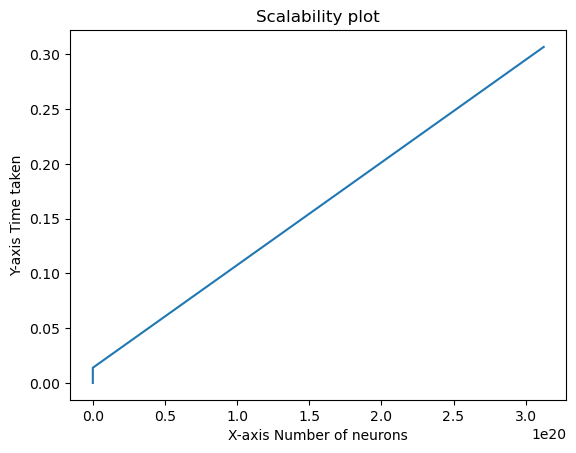

In [180]:
#plot a graph and see the scalability , x axis represents the size of the neuron network and y axis represents 
#the time taken 
import matplotlib.pyplot as plt

x = [32,32000,3200000,312500000,10000000000,312500000000000000000 ]
y = [0.0001070,0.00047588,0.00079,0.0036, 0.0139295,0.30663]

# Create a line plot
plt.plot(x, y)

# Add labels and a title
plt.xlabel('X-axis Number of neurons')
plt.ylabel('Y-axis Time taken')
plt.title('Scalability plot')

# Show the plot 
plt.show()

#time taken increases exponentially as the number of neurons increases.